# Prérequis
En utilisant pip, conda ou autre, il faudra installer les modules python suivants:
* numpy
* pandas
* scipy
* scikit-learn
* matplotlib
* pygam

# Prise en main du ficher de données
Les données que nous allons utiliser sont des données qui indiquent le coût de l'assurance maladie pour plus de 1300 personnes.
Une personne est décrite par:
- son âge
- son sexe
- sa masse corporelle
- son nombre d'enfants
- si elle fume ou pas
- la région dans laquelle elle vit
- le coût de son assurance.

Nous allons dans un premier temps prendre en main le fichier de données.

In [1]:
import pandas as pd
data = pd.read_csv(r'insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


On remarque:
- qu'il y a 7 colonnes, 1338 lignes
- qu'il n'y a pas de valeurs manquantes
- qu'il y a 3 colonnes catégorielles (object).

Affichez les modalités (les valeurs possibles pour chacune de ces colonnes) ainsi que l'effectif correspondant.

In [2]:
for col in ["sex", "smoker", "region"]:
    print(col)
    print("Effectif:", len(data[col].unique()))
    print("Données:", data[col].unique())
    

sex
Effectif: 2
Données: ['female' 'male']
smoker
Effectif: 2
Données: ['yes' 'no']
region
Effectif: 4
Données: ['southwest' 'southeast' 'northwest' 'northeast']


<IPython.core.display.Javascript object>


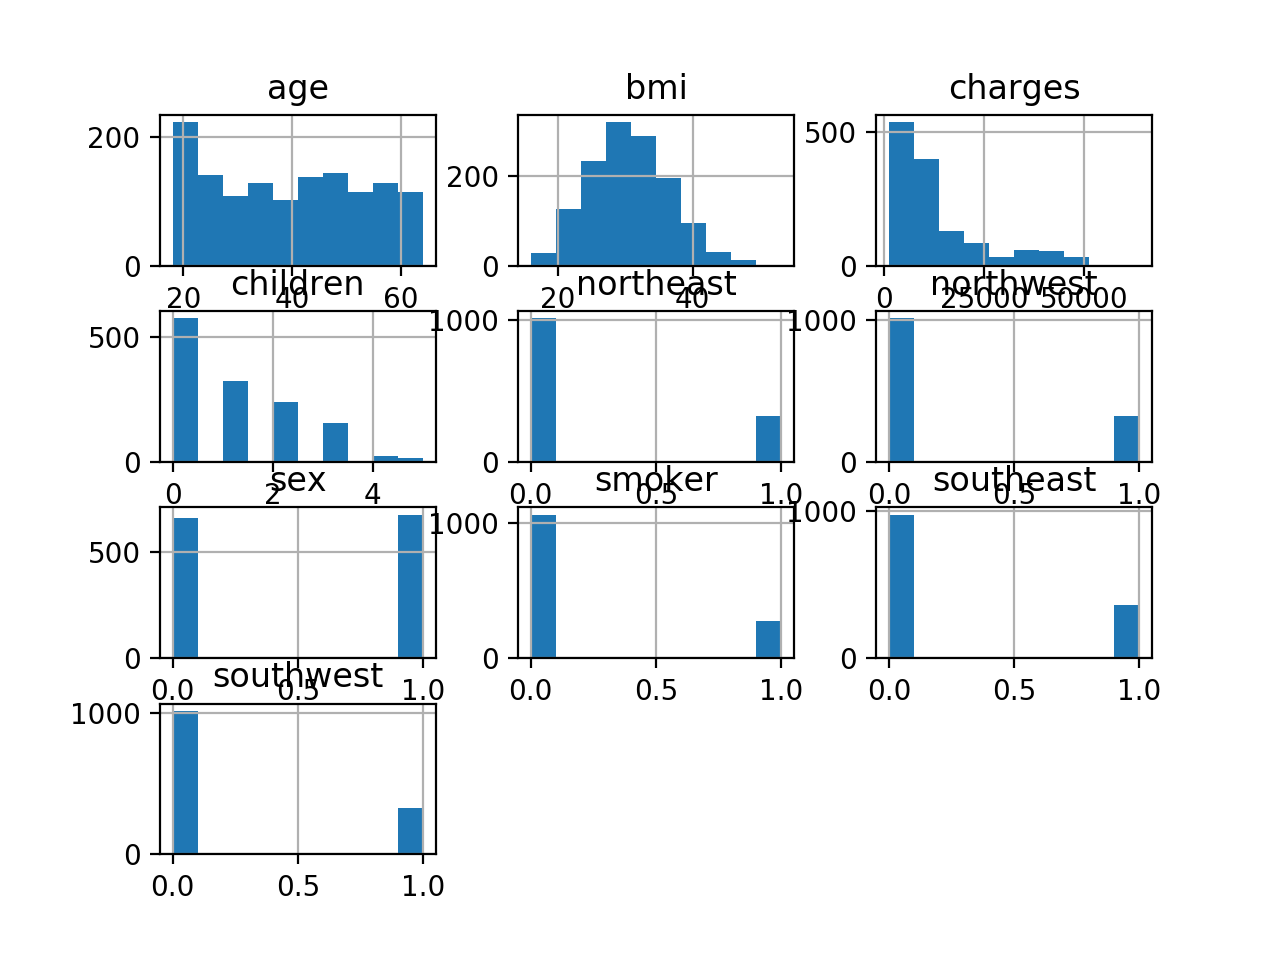

In [14]:
import matplotlib.pyplot as plt
# %matplotlib inline
data.hist()
plt.show()

Que pouvez-vous dire sur l'équilibre du jeu de données ? Apprendre sur ce dernier va-t-il poser un problème de représentativité ?

In [37]:
#entrez ici votre réponse entre 
""" D'apres les differents histogrammes ci dessus, on voit que les données ne sont pas équilibrés par rapport à la repartiton de tous les features.
La plupart des features sont déséquilibrés sauf l'age qui semble assez bien réparti. Il y a de forte chance que le modele soit biaisé dans ce cas. 
Cependant, puisque nous nous interessons à l'explication, ce n'est pas trop genant car on veut découvrir la logique derriere une decision.
"""

" D'apres les differents histogrammes ci dessus, on voit que les données ne sont pas équilibrés par rapport à la repartiton de tous les features.\nLa plupart des features sont déséquilibrés sauf l'age qui semble assez bien réparti. Il y a de forte chance que le modele soit biaisé dans ce cas. \nCependant, puisque nous nous interessons à l'explication, ce n'est pas trop genant car on veut découvrir la logique derriere une decision.\n"

# Régression linéaire
Nous allons appliquer dans un premier temps la régression linéaire. Cependant, elle ne prend pas correctement en compte les données catégorielles.
Nous allons devoir les transformer.

## Adaptation du jeu de données
La régression linéaire ne gère pas très bien les données catégorielles, en particulier quand elles ne sont pas ordonnées.
Classiquement, on transforme:
    - les données binaires ou à 2 modalités en 0 et 1
    - les données à au moins 3 modalités en un codage binaire de ces modalités: on se retrouve avec autant de colonnes bonaires qu'il y a de modalités.
Pour les colonnes a deux modalités, on peut directement les transformer avec une méthode de conversion.

In [5]:
def YesNoConverter(val):
    if val=="yes": return 1
    else: return 0

data["smoker"] = data["smoker"].apply(YesNoConverter)

In [6]:
#faire la même chose ici
def MaleFemaleConverter(val):
    if val=="male": return 1
    else: return 0
    
data["sex"] = data["sex"].apply(MaleFemaleConverter)

Pour la dernière colonne, nous allons utiliser la fonction  [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) qui fait tout le travail à notre place. Il faudra ensuite insérer les colonnes créées avec [concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) et supprimer la colonne originale avec [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html).

In [7]:
region_df = pd.get_dummies(data["region"])
data = pd.concat([data, region_df], axis=1)
data = data.drop(["region"], axis=1)
data.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


## Régression linéaire
Maintenant que le jeu de données est prêt, utilisez [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) de scikit learn pour obtenir un modèle linéaire.

In [8]:
import sklearn
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

X = data.drop("charges", axis=1)
y = data["charges"]

lin_reg.fit(X, y)

intercept = lin_reg.intercept_
slope = lin_reg.coef_

## Interprétation
Maintenant que vous avez un modèle entraînez, mettez en oeuvre ce que nous avons vu en cours (et plus!) pour l'interpréter. Utilisez au moins les poids, la SE et le t pour chaque coefficient.

In [9]:
import numpy as np 

sse = np.sum((lin_reg.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
se = np.array(np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X)))))
t = lin_reg.coef_/se

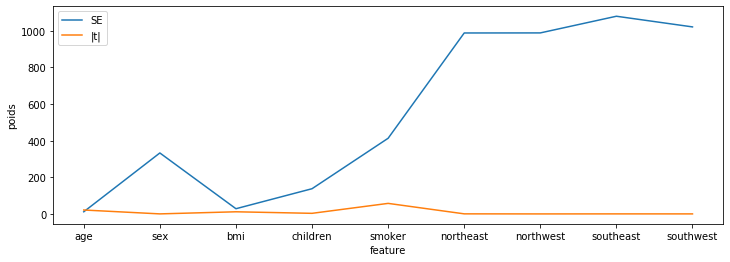

In [46]:
feature_names = list(X.columns)
plt.figure(figsize=(12, 4))
plt.plot(feature_names, se, label="SE")
plt.plot(feature_names, abs(t), label="|t|")
plt.xlabel("feature")
plt.ylabel("poids")
plt.legend()
plt.show()

In [47]:
print("Valeur absolue de t pour chaque feature.")
for feat, t_i in sorted(zip(feature_names, abs(t)), key=lambda x: x[1], reverse=True):
    print(feat, ":", t_i)

Valeur absolue de t pour chaque feature.
smoker : 57.72320196310965
age : 21.586655230823112
bmi : 11.860130552343854
children : 3.450554598728476
northeast : 0.5942476617068531
southeast : 0.41515033973139115
sex : 0.3944020369748759
southwest : 0.3653818258408018
northwest : 0.23684103113134633


In [52]:
#Tapez ici votre interpretation (que révèle le modèle?)
""" 
La valeur absolue de la t-statistique indique l’importance d’une feature.
Les variables les plus importantes selon la t-statistique sont au nombre de trois, les autres etant negligeables en comparaison.
La variable smoker explique le plus les données avec un score de 58, ensuite la variable age avec un score de 22 et puis le bmi avec un score de 12.
"""


' \nLa valeur absolue de la t-statistique indique l’importance d’une feature.\nLes variables les plus importantes selon la t-statistique sont au nombre de trois, les autres etant negligeables en comparaison.\nLa variable smoker explique le plus les données avec un score de 58, ensuite la variable age avec un score de 22 et puis le bmi avec un score de 12.\n'

In [54]:
#Concluez sur l'utilisation de ce modèle pour ce dataset
"""
Etant donné que les variables les plus importantes sont binaires ou categorielles voire discrets, une regression lineaire ne semble pas etre le modele le plus pertinent.
"""

'\nEtant donné que les variables les plus importantes sont binaires ou categorielles voire discrets, une regression lineaire ne semble pas etre le modele le plus pertinent.\n'

# Arbre de régression
Nous allons à présent tester un deuxième modèle: les arbres de régression. Normalement, la plupart des algorithmes acceptent tous les types de données. Cependant, l'implémentation de scikit learn ne le permet pas. Nous allons donc conserver notre jeu de données tel que pré-traité auparavant.

J'attire sur votre attention que le problème ne vient pas des colonnes binaires (à deux modalités). En revanche, pour les colonnes catégorielles à plus de 2 modalités, l'implémentation de scikit learn traiterait plutôt des valeurs ordinales, et ce n'est pas le cas des régions chez nous. Vous trouverez sur le net des tas d'astuces qui vous diront de remplacer les modalités par des nombres, etc. Elles ne me paraissent pas judicieuses dans notre cas. Aussi, lors de l'interprétation du modèle, je vous demande de prendre avec précautions les 4 colonnes "région".

## Entraînement
Entraînez un arbre de régression avec [scikit learn](https://scikit-learn.org/stable/modules/tree.html). Ne laissez pas les valeurs par défaut dans le constructeur, car sinon votre arbre sera très profond (et donc pas interprétable). Ajustez les paramètres tout en maintenant un taux de classification élevé. 
Remarque: pour cet exercice, il n'est pas nécessaire de mettre en place une cross-validation (on fait de la régression). On peut utilisé le taux de classification sur l'ensemble d'apprentissage ou un sous-ensemble, cela suffit pour cet exercice en tout cas.

In [29]:
%matplotlib inline
from sklearn import tree
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)


DecisionTreeRegressor(max_depth=5)

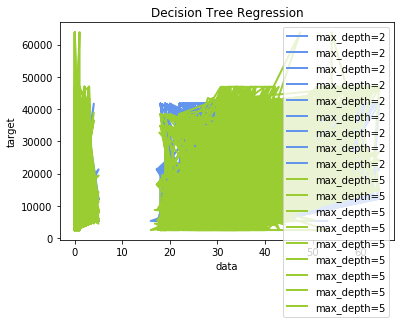

In [28]:
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Plot the results
plt.figure()
# plt.scatter(X, y, s=20, edgecolor="black",
#             c="darkorange", label="data")
plt.plot(X, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Prenez la dernière ligne du jeu de données, et retrouvez le chemin de la décision dans l'arbre avec la méthode [decision_path](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.decision_path). L'idée est de connaître la liste des tests par lesquels l'instance est passée.

In [59]:
tree_reg = regr_2
X_test = np.array(X.tail(1))
node_indicator = tree_reg.decision_path(X_test)
leaf_id = tree_reg.apply(X_test)
feature = tree_reg.tree_.feature
threshold = tree_reg.tree_.threshold

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample {id}:\n'.format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature_names[feature[node_id]],
              value=X_test[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))

Rules used to predict sample 0:

decision node 0 : (X_test[0, smoker] = 1.0) > 0.5)
decision node 32 : (X_test[0, bmi] = 29.07) <= 30.010000228881836)
decision node 33 : (X_test[0, age] = 61.0) > 41.0)
decision node 41 : (X_test[0, bmi] = 29.07) > 25.960000038146973)
decision node 45 : (X_test[0, bmi] = 29.07) > 26.09749984741211)


In [68]:
tree_feature_importance = sorted(zip(feature_names, list(tree_reg.tree_.compute_feature_importances())), key=lambda x: x[1], reverse=True)
print("Importance des features de la Decision tree:")
for feat, imp in tree_feature_importance:
    print(feat, imp)

Importance des features de la Decision tree:
smoker 0.7039513587060109
bmi 0.17172948730429446
age 0.11275932206027806
children 0.009553874697551933
northeast 0.001633823417959317
southeast 0.0003721338139053863
sex 0.0
northwest 0.0
southwest 0.0


## Interprétation
A présent, interprétez le modèle (intéressez-vous à la feature importance). Que révèle l'arbre?

In [69]:
#tapez ici votre interprétation entre """ """

""" 
D'apres la decision path de l'arbre de decision, la variable smoker est d'abord traité et comparé à la v aleur de 0.5. Ce qui fait sens car la variable smoker est binaire.
Ensuite le bmi est regardé et comparé par rapport à la valeur de 30. Ensuite vient l'age comparé à 41, puis le bmi est enncore regardé pour raffiner la prediction.
On voit que l'arbre de decision s'est essentiellement basé sur les features "smoker", "bmi" et "age" qui d'apres les feature importance de l'AD sont les features les plus importants.

"""

' \nD\'apres la decision path de l\'arbre de decision, la variable smoker est d\'abord traité et comparé à la v aleur de 0.5. Ce qui fait sens car la variable smoker est binaire.\nEnsuite le bmi est regardé et comparé par rapport à la valeur de 30. Ensuite vient l\'age comparé à 41, puis le bmi est enncore regardé pour raffiner la prediction.\nOn voit que l\'arbre de decision s\'est essentiellement basé sur les features "smoker", "bmi" et "age" qui d\'apres les feature importance de l\'AD sont les features les plus importants.\n\n'

# GAM
Nous allons passer au troisième type de modèle: les GAM.

## Entraînement
En utilisant le module pyGam, entraînez un GAM pour notre tâche de régression. Ne laissez pas les paramètres par défaut.

In [16]:
from pygam import LinearGAM, s


In [22]:
lams = np.random.rand(100, 9)
lams = lams * 9 - 3
lams = np.exp(lams)
print(lams.shape)

(100, 9)


In [24]:
model3 = LinearGAM(n_splines=10).gridsearch(X.to_numpy(), y.to_numpy(), lam=lams)

100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


Pourquoi avez-vous choisi cette architecture de GAM?

In [72]:
#tapez ici votre justification entre
"""
Nous avons effectué un gridsearch sur plusieurs valeurs de lam.

"""

'\nNous avons effectué un gridsearch sur plusieurs valeurs de lam.\n\n'

## Interprétation
Visualisez les termes de votre GAM. On vous donne le code :).

<Figure size 432x288 with 0 Axes>

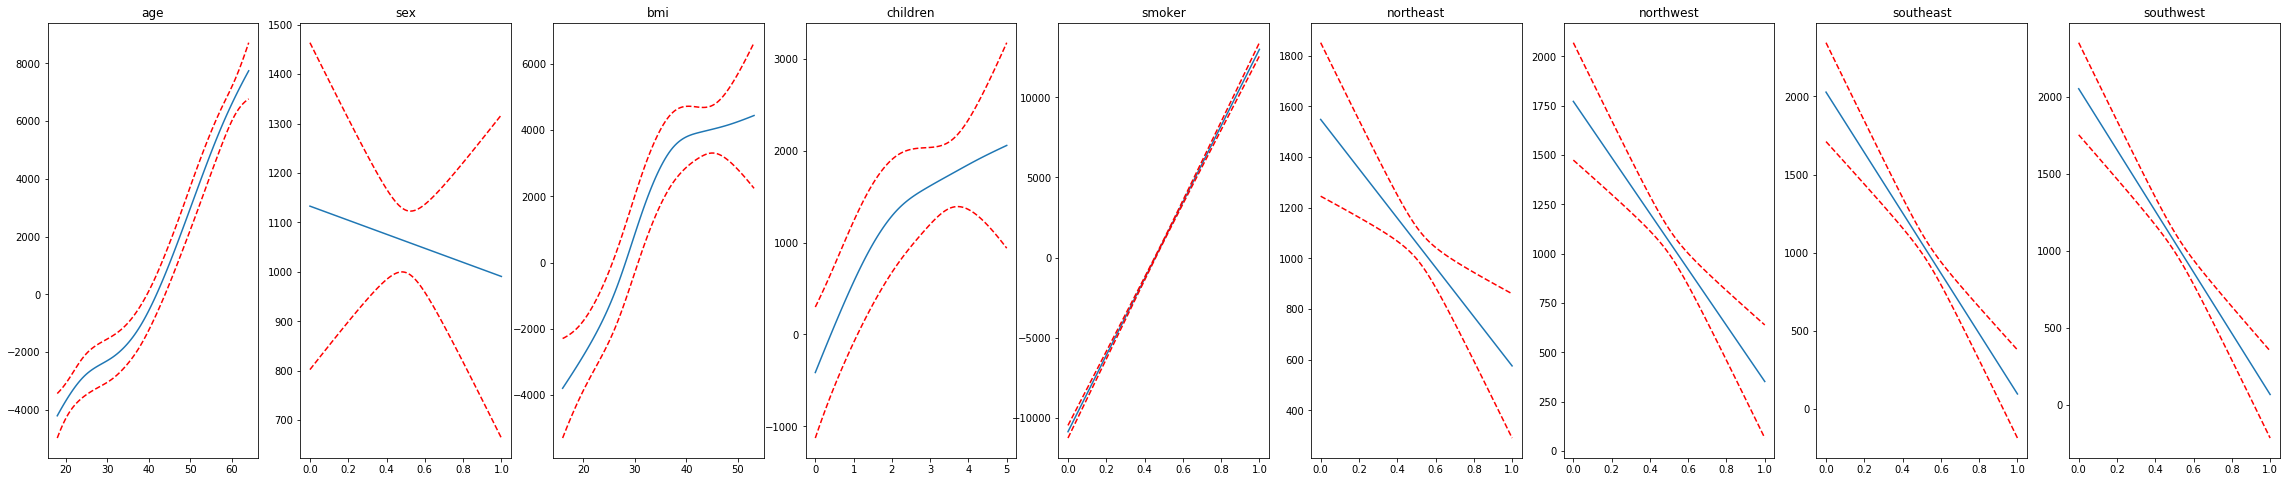

In [35]:
titles = X.columns
plt.figure()
fig, axs = plt.subplots(1,9,figsize=(40, 8))
terms = model3.terms
for i, ax in enumerate(axs):
    if terms[i].isintercept:
        continue
    XX = model3.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])

In [36]:
# for i, term in enumerate(model3.terms):
#     if term.isintercept:
#         continue

#     XX = model3.generate_X_grid(term=i)
#     pdep, confi = model3.partial_dependence(term=i, X=XX, width=0.95)

#     plt.figure()
#     plt.plot(XX[:, term.feature], pdep)
#     plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#     plt.title(repr(term))
#     plt.show()

Quelles informations tirez-vous du GAM ?

In [70]:
#Votre réponse ici entre 
"""
D'apres ces graphes, nous avons une allure croissante pour les variables, 'age, 'smoker', 'bmi', et 'children', les autres etant decroissantes.
Les variables 'smoker', 'bmi' et 'age' sont plus lineaires et avec une pente plus eleves, ce qui suggere qu'ils sont les variables les plus explicatives de notre dataset.
"""

"\nD'apres ces graphes, nous avons une allure croissante pour les variables, 'age, 'smoker', 'bmi', et 'children', les autres etant decroissantes.\nLes variables 'smoker', 'bmi' et 'age' sont plus lineaires et avec une pente plus eleves, ce qui suggere qu'ils sont les variables les plus explicatives de notre dataset.\n"

# Conclusion
Indiquez ce que les différents modèles vous ont apporté comme connaissances sur les données et le fonctionnement de ces modèles.

In [71]:
#Votre réponse ici entre 
""" 
Nous avons travaillé sur des modeles interpretables simples mais assez puissant pour avoir des performance correctes.
Ces differents modèles nous ont permis de connaitre differents mecanismes de prise de decision. Ils s'accordent pour signifier que les variables les plus importants dans notre dataset sont 'smoker', 'bmi' et 'age'.
"""

" \nNous avons travaillé sur des modeles interpretables simples mais assez puissant pour avoir des performance correctes.\nCes differents modèles nous ont permis de connaitre differents mecanismes de prise de decision. Ils s'accordent pour signifier que les variables les plus importants dans notre dataset sont 'smoker', 'bmi' et 'age'.\n"